In [438]:
using Plots

using LinearAlgebra
using ForwardDiff
using Interpolations

using JSON
using Geodesy

In [439]:
function rearwheel_dynamics(x, u, params)
    l = params.l
    v = params.v

    px, py, θ = x
    δ = u[1]

    return [
        v * cos(θ);
        v * sin(θ);
        v / l * tan(δ)
    ]
end

rearwheel_dynamics (generic function with 1 method)

In [440]:
function rk4(xₖ, uₖ, dt, dynamics::F, params) where {F}
    k1 = dynamics(xₖ, uₖ, params)
    k2 = dynamics(xₖ + k1*dt/2, uₖ, params)
    k3 = dynamics(xₖ + k2*dt/2, uₖ, params)
    k4 = dynamics(xₖ + k3*dt, uₖ, params)

    xₖ₊₁ = xₖ + dt * (k1 + 2k2 + 2k3 + k4) / 6
    return xₖ₊₁
end

function step(x, u, dt, params)
    return rk4(x, u, dt, rearwheel_dynamics, params)
end

step (generic function with 1 method)

In [441]:
function naive_stanley_steering(e, ψ, params)
    k = params.k
    v = params.v
    δₘₐₓ = params.δₘₐₓ

    δ = ψ + atan(k * e / v)
    δ = clamp(δ, -δₘₐₓ, δₘₐₓ)
    return δ
end

naive_stanley_steering (generic function with 1 method)

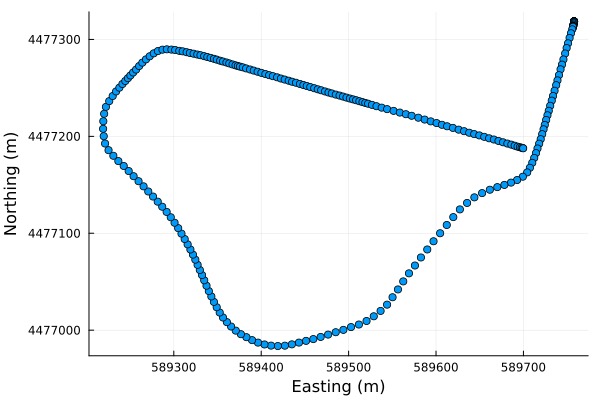

In [442]:
# Load course trajectory
json_data = JSON.parsefile("buggycourse_raceline.json")
latlon_vec = [LLA(x["lat"], x["lon"], 0.0) for x in json_data]
lla_to_utm = UTMfromLLA(17, true, wgs84)
utm_vec = map(lla_to_utm, latlon_vec)

x_traj_raw = [p.x for p in utm_vec]
y_traj_raw = [p.y for p in utm_vec]

scatter(x_traj_raw, y_traj_raw, label=nothing,
    xlabel="Easting (m)", ylabel="Northing (m)")

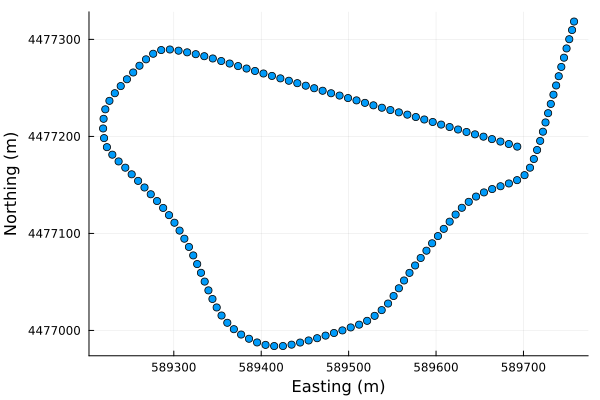

In [443]:
# Re-sample by arc-length
distances = zeros(length(x_traj_raw))
for i in 1:(length(distances)-1)
    distances[i+1] = distances[i] + √((x_traj_raw[i+1] - x_traj_raw[i])^2 + (y_traj_raw[i+1] - y_traj_raw[i])^2)
end

tot_len = distances[end]
x_traj_lin = linear_interpolation(distances, x_traj_raw)
y_traj_lin = linear_interpolation(distances, y_traj_raw)
scatter(x_traj_lin.(0.0:10.0:tot_len), y_traj_lin.(0.0:10.0:tot_len), label=nothing,
    xlabel="Easting (m)", ylabel="Northing (m)")

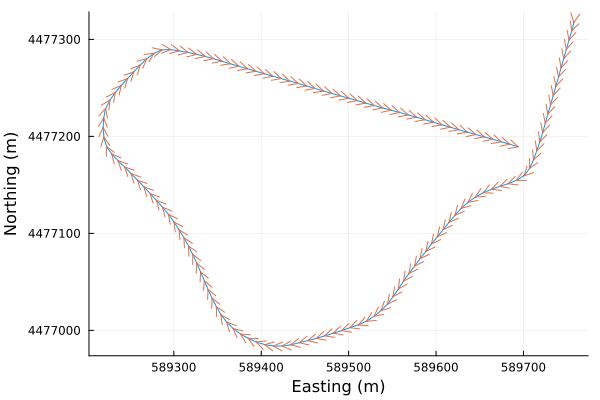

In [444]:
d = range(0.0, stop=tot_len, length=length(x_traj_raw))
x_traj_cubic = cubic_spline_interpolation(d, x_traj_lin.(d))
y_traj_cubic = cubic_spline_interpolation(d, y_traj_lin.(d))

d_c = 0.0:10.0:tot_len
plot(x_traj_cubic.(d_c), y_traj_cubic.(d_c), label=nothing,
    xlabel="Easting (m)", ylabel="Northing (m)")
quiver!(x_traj_cubic.(d_c), y_traj_cubic.(d_c), quiver=([ForwardDiff.derivative(x_traj_cubic, t) for t in d_c], [ForwardDiff.derivative(y_traj_cubic, t) for t in d_c]))

In [445]:
function naive_stanley_controller(x, params)
    px, py, θ = x
    l = params.l
    v = params.v
    traj_x = params.traj_x
    traj_y = params.traj_y
    tot_len = params.tot_len

    pxf = px + l*cos(θ)
    pyf = py + l*sin(θ)

    coarse_sampling = 0.0:5.0:tot_len
    coarse_choice = argmin(t -> (traj_x(t) - pxf)^2 + (traj_y(t) - pyf)^2, coarse_sampling)

    fine_sampling = (coarse_choice - 5.0):0.01:(coarse_choice + 5.0)
    fine_choice = argmin(t -> (traj_x(t) - pxf)^2 + (traj_y(t) - pyf)^2, fine_sampling)

    e = √((traj_x(fine_choice) - pxf)^2 + (traj_y(fine_choice) - pyf)^2)
    d_vec = [ForwardDiff.derivative(traj_x, fine_choice + params.lookahead); ForwardDiff.derivative(traj_y, fine_choice + params.lookahead)]
    n_vec = [-d_vec[2]; d_vec[1]]

    e *= sign(n_vec ⋅ [(traj_x(fine_choice) - pxf); (traj_y(fine_choice) - pyf)])
    ψ = atan(d_vec[2], d_vec[1]) - θ
    ψ = atan(sin(ψ), cos(ψ)) + params.heading_error_offset

    δ = naive_stanley_steering(e, ψ, params) + params.steering_offset
    return δ, e
end

naive_stanley_controller (generic function with 1 method)

In [446]:
function simulate_buggy_deterministic(x0, dt, tf, params, controller::F) where {F}
    Nk = ceil(Int, tf / dt)
    X = zeros(3, Nk)
    U = zeros(1, Nk)
    E = zeros(1, Nk)
    X[:, 1] .= x0

    for k in 1:(Nk-1)
        δ, e = naive_stanley_controller(@view(X[:, k]), params)
        U[:, k] .= δ
        E[:, k] .= e
        X[:, k+1] = step(@view(X[:, k]), @view(U[:, k]), dt, params)
    end

    return X, U, E
end

simulate_buggy_deterministic (generic function with 1 method)

In [447]:
# Set up system parameters
params = (
    v = 14.0,   # m/s
    l = 1.2,    # m
    k = 1.3,
    δₘₐₓ = π / 9.0, # rad, i.e. 20°
    traj_x = x_traj_cubic,
    traj_y = y_traj_cubic,
    tot_len = tot_len,
    lookahead = 0.0,
    steering_offset = 0.0,
    heading_error_offset = 0.0
);

x0 = [589750.0; 4477300.0; -π / 2]
dt = 0.01
tf = 90.0

X, U, E = simulate_buggy_deterministic(x0, dt, tf, params, naive_stanley_controller)

([589750.0 589749.9989006425 … 589616.3450091168 589616.4808179492; 4.4773e6 4.477299860005755e6 … 4.47720946280884e6 4.477209428809416e6; -1.5707963267948966 -1.586501756949953 … -6.528318785093393 -6.5286635330979355], [-0.1338135195502278 -0.12091937271903141 … -0.0029549742952324175 0.0], [1.8714951822274508 1.8483521905103604 … -0.0027527465157423294 0.0])

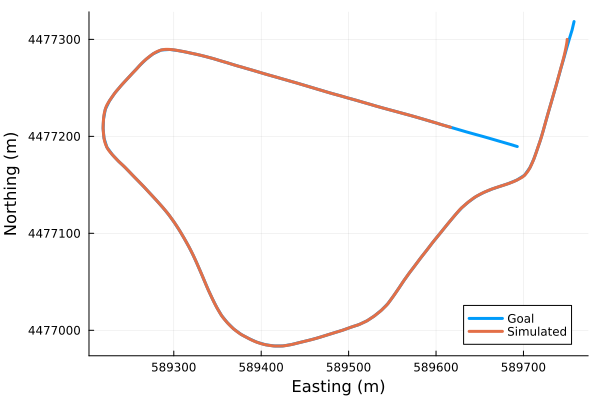

In [448]:
plot(x_traj_cubic.(d_c), y_traj_cubic.(d_c), label="Goal",
    xlabel="Easting (m)", ylabel="Northing (m)", linewidth=3.0)
plot!(X[1, :], X[2, :], label="Simulated",  linewidth=3.0)

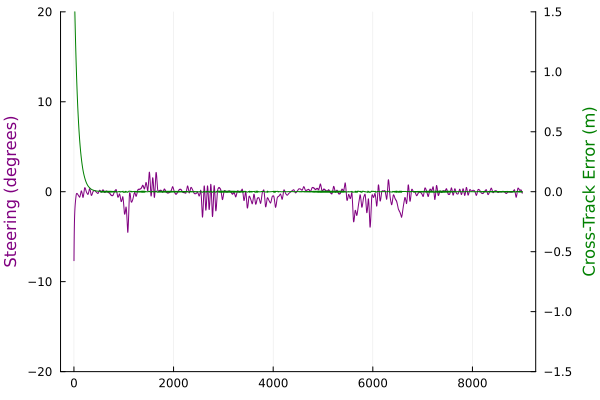

In [449]:
plot(U[1, :] .* 180.0 / π, ylabel="Steering (degrees)", ylims=(-20, 20), color=:purple, yguidefontcolor=:purple, label=nothing)
plot!(twinx(), E[1, :], ylabel="Cross-Track Error (m)", ylims=(-1.5, 1.5), color=:green, yguidefontcolor=:green, label=nothing)